# Hierarchical Clustering

Hierarchical clustering is a method of cluster analysis that seeks to build a hierarchy of clusters (not just partition of the sample into disjoint sets, but a system of nested partitions).

There are two stategies for hierachy clustering:
* Divisive or top-down algorithms split the sample into smaller and smaller clusters
* Agglomerative or bottom-up algorithms, in which objects are combined into larger and larger clusters
 

<img src="assets/aglo_and_divisive.jpeg" width="600" height="300">


The agglomerative approach is more popular and effective. The algorithm itself looks pretty simple and consists of the following steps:
* Create as many clusters as there are objects, each object in its own separate cluster.
* Iteratively repeat the merging of the two closest clusters until the stopping criterion is met.

## Linkage and Distance

At first, each object is considered as one cluster. For single element clusters, the distance function is naturally defined:

$
R(\{\boldsymbol x\},\{\boldsymbol y\})=\rho (\boldsymbol x, \boldsymbol y)
$

The distances between objects $\rho$ can be specified by any metric, both Euclidean and Manhattan distance or, for example, the cosine measure.

Then the process of clusters merging starts. At each iteration, instead of the pair of closest clusters $U$ and $V$, a new cluster $W = U \cup V$ is formed. There are several methods of identifing closest clusters:

* Single linkage aka Nearest Point Algorithm: 
$
\hspace{2mm} R_{min}(U, V)=\min\limits_{u \in U, v \in V}\rho (u, v)
$
* Complete linkage aka Farthest Point Algorithm: 
$
\hspace{2mm} R_{max}(U, V)=\max\limits_{u \in U, v \in V}\rho (u, v)
$
* Unweighted Pair Group Method with Arithmetic mean (UPGMA): 
$
\hspace{2mm} R_{avg}(U, V)=\dfrac{1}{|U|\cdot|V|}\sum\limits_{u \in U}\sum\limits_{v \in V}\rho (u, v)
$
* Unweighted Pair Group Method with Centroid average (UPGMC): 
$
\hspace{2mm} R_{cen}(U, V)=\rho^2(\sum\limits_{u \in U}\dfrac{u}{|U|}, \sum\limits_{v \in V}\dfrac{v}{|V|})
$
* Ward's method: 
$
\hspace{2mm} R_{ward}(U, V)=\dfrac{|U|\cdot|V|}{|U|+|V|}\rho^2(\sum\limits_{u \in U}\dfrac{u}{|U|}, \sum\limits_{v \in V}\dfrac{v}{|V|})
$

<br>
At each step, it is good to be able to quickly calculate the distance from the formed cluster $W = U \cup V$ to any other cluster $S$, using known distances from previous steps. This is easily accomplished using the equation proposed by Lance and Williams in 1967:

$
R(W,S)=\alpha_{U}\cdot R(U,S)+\alpha_{V}\cdot R(V,S)+\beta\cdot R(U,V)+\gamma\cdot|R(U,S)−R(V,S)|
$

$\alpha_{U}, \alpha_{V}, \beta, \gamma - $ some parameters

For each of the above distance functions, compliance with the Lance-Williams equation has been proven for certain combinations of parameters
* Single linkage: $\alpha_{U}=0.5, \alpha_{V}=0.5, \beta=0, \gamma=-0.5$

* Complete linkage: $\alpha_{U}=0.5, \alpha_{V}=0.5, \beta=0, \gamma=0.5$
* UPGMA: $\alpha_{U}=\dfrac{|U|}{|W|}, \alpha_{V}=\dfrac{|V|}{|W|}, \beta=0, \gamma=0$
* UPGMC: $\alpha_{U}=\dfrac{|U|}{|W|}, \alpha_{V}=\dfrac{|V|}{|W|}, \beta=-\alpha_{U}\cdot \alpha_{V}, \gamma=0$
* Ward's method: $\alpha_{U}=\dfrac{|S|+|U|}{|S|+|W|}, \alpha_{V}=\dfrac{|S|+|V|}{|S|+|W|}, \beta=\dfrac{-|S|}{|S|+|W|}, \gamma=0$

## Dendrogram
As clusters merge, each iteration of the algorithm corresponds to a pair of clusters merged at this iteration, as well as the distance between the clusters at the moment of merging. Distances will only increase with iteration, so it becomes possible to visualize the result in the form of a beautiful cluster tree called a <b>dendrogram.

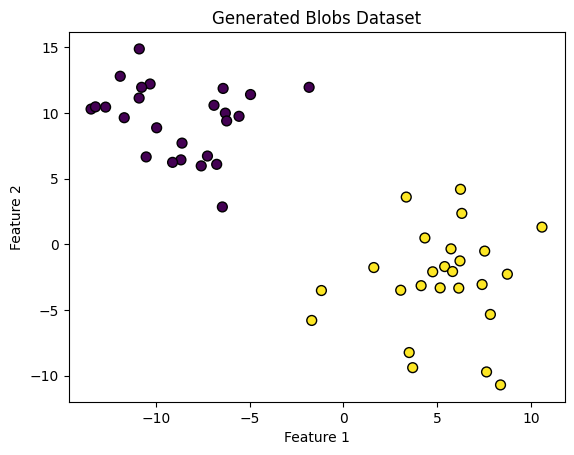

In [223]:
from sklearn.datasets import make_blobs, make_moons, make_circles
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt


X, y = make_blobs(n_samples=50, centers=2, cluster_std=3, random_state=47)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=50, edgecolors='k')
plt.title("Generated Blobs Dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [224]:
import plotly.figure_factory as ff
import plotly.graph_objects as go


fig = go.Figure()
trace_cnt = []
layouts = []

linkage_methods = ['single', 'complete', 'average', 'centroid', 'ward']
num_clusters = 2

for linkage_method in linkage_methods:

    dendrogram = ff.create_dendrogram(
        X, labels=y,
        linkagefun=lambda x: linkage(x, method=linkage_method)
    )

    trace_cnt.append(len(dendrogram.data))
    
    for data in dendrogram.data:
        data.visible = False
        data.showlegend = False
        fig.add_trace(data)

    layouts.append(dendrogram.layout)

    # agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage_method)
    # cluster_labels = agg_clustering.fit_predict(X)

    # fig.add_trace(
    #     go.Scatter(
    #         x=X[:, 0],
    #         y=X[:, 1],
    #         marker=dict(size=cluster_labels),
    #         visible=False
    #     ),
    #     row=1, col=2
    # )

    # fig.add_la
fig.update_layout(
    title={"text": "Dendrogram", "x": 0.5, "y": 0.95},
    xaxis=layouts[0]["xaxis"],
    yaxis=layouts[0]["yaxis"],
)

for i in range(trace_cnt[0]):
    fig.data[i].visible = True

fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            showactive=True,
            x=0.13,
            xanchor="left",
            y=1.20,
            yanchor="top",
            pad={"r": 10, "t": 10},
            buttons=list([
                dict(label=linkage_method,
                     method="update",
                     args=[{"visible": [False] * sum(trace_cnt[:i]) + [True] * trace_cnt[i]  + [False] * sum(trace_cnt[i:])},
                           {"xaxis": layouts[i]["xaxis"], "yaxis": layouts[i]["yaxis"]}])
                for i, linkage_method in enumerate(linkage_methods)
            ]),
        )
    ])

fig.update_layout(
    annotations=[
        dict(text="Linkage method:", showarrow=False, x=30, y=1.13, yref="paper", align="left")
    ]
)

fig.show()


In [7]:
from sklearn.cluster import AgglomerativeClustering

num_clusters = 2
agg_clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='single')
cluster_labels = agg_clustering.fit_predict(X)